# SRGAN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
import os
sys.path.append(os.path.abspath('/content/drive/My Drive/Colab Notebooks/super-resolution'))

In [0]:
import os
import matplotlib.pyplot as plt

from data import DIV2K
from model.srgan import generator, discriminator
from train import SrganTrainer, SrganGeneratorTrainer
import tensorflow as tf

tf.enable_eager_execution()

%matplotlib inline

In [0]:
# Location of model weights (needed for demo)
# weights_dir = 'weights/srgan'
weights_dir = '/content/drive/My Drive/Colab Notebooks/super-resolution/weights/SRGAN/'
weights_file = lambda filename: os.path.join(weights_dir, filename)

os.makedirs(weights_dir, exist_ok=True)

## Datasets

You don't need to download the DIV2K dataset as the required parts are automatically downloaded by the `DIV2K` class. By default, DIV2K images are stored in folder `.div2k` in the project's root directory.

In [5]:
'''
div2k_train = DIV2K(scale=4, subset='train', downgrade='bicubic')
div2k_valid = DIV2K(scale=4, subset='valid', downgrade='bicubic')
'''

"\ndiv2k_train = DIV2K(scale=4, subset='train', downgrade='bicubic')\ndiv2k_valid = DIV2K(scale=4, subset='valid', downgrade='bicubic')\n"

In [6]:
'''
import tensorflow as tf

train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=16, random_transform=True, repeat_count=1)
'''

'\nimport tensorflow as tf\n\ntrain_ds = div2k_train.dataset(batch_size=16, random_transform=True)\nvalid_ds = div2k_valid.dataset(batch_size=16, random_transform=True, repeat_count=1)\n'

## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-srgan.tar.gz](https://drive.google.com/open?id=1u9ituA3ScttN9Vi-UkALmpO0dWQLm8Rv) and extract the archive in the project's root directory. This will create a folder `weights/srgan` containing the weights of the pre-trained models.

### Generator pre-training

In [7]:
'''
pre_trainer = SrganGeneratorTrainer(model=generator(), checkpoint_dir=f'.ckpt/pre_generator')
pre_trainer.train(train_ds,
                  valid_ds.take(10),
                  steps=1000000, 
                  evaluate_every=1000, 
                  save_best_only=False)

pre_trainer.model.save_weights(weights_file('pre_generator.h5'))
'''

"\npre_trainer = SrganGeneratorTrainer(model=generator(), checkpoint_dir=f'.ckpt/pre_generator')\npre_trainer.train(train_ds,\n                  valid_ds.take(10),\n                  steps=1000000, \n                  evaluate_every=1000, \n                  save_best_only=False)\n\npre_trainer.model.save_weights(weights_file('pre_generator.h5'))\n"

### Generator fine-tuning (GAN)

In [8]:
'''
gan_generator = generator()
gan_generator.load_weights(weights_file('pre_generator.h5'))

gan_trainer = SrganTrainer(generator=gan_generator, discriminator=discriminator())
gan_trainer.train(train_ds, steps=200000)
'''

"\ngan_generator = generator()\ngan_generator.load_weights(weights_file('pre_generator.h5'))\n\ngan_trainer = SrganTrainer(generator=gan_generator, discriminator=discriminator())\ngan_trainer.train(train_ds, steps=200000)\n"

In [9]:
'''
gan_trainer.generator.save_weights(weights_file('gan_generator.h5'))
gan_trainer.discriminator.save_weights(weights_file('gan_discriminator.h5'))
'''

"\ngan_trainer.generator.save_weights(weights_file('gan_generator.h5'))\ngan_trainer.discriminator.save_weights(weights_file('gan_discriminator.h5'))\n"

## Demo

In [0]:
pre_generator = generator()
gan_generator = generator()

pre_generator.load_weights(weights_file('pre_generator.h5'))
gan_generator.load_weights(weights_file('gan_generator.h5'))

In [0]:
from model import resolve_single
from utils import load_image
from PIL import Image

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    
    pre_sr = resolve_single(pre_generator, lr)
    gan_sr = resolve_single(gan_generator, lr)
    
    plt.figure(figsize=(20, 20))
    
    images = [lr, pre_sr, gan_sr]
    titles = ['LR', 'SR (PRE)', 'SR (GAN)']
    positions = [1, 3, 4]
    
    for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
        plt.subplot(2, 2, pos)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

def resolve_and_plot_2(lr_image_path):
    lr = load_image(lr_image_path)
    gan_sr = resolve_single(gan_generator, lr)
    
    plt.figure(figsize=(20, 20))
    
    images = [lr, gan_sr]
    titles = ['LR', 'SR (GAN)']
    positions = [1, 2]
    
    for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
        plt.subplot(2, 2, pos)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
  
    # image = Image.fromarray(gan_sr)
    # image.save('example.jpeg', format='JPEG')

In [0]:
example_dir = '/content/drive/My Drive/Colab Notebooks/super-resolution/'

In [0]:
# resolve_and_plot(os.path.join(example_dir, 'demo/0869x4-crop.png'))

In [0]:
# resolve_and_plot(os.path.join(example_dir, 'demo/0829x4-crop.png'))

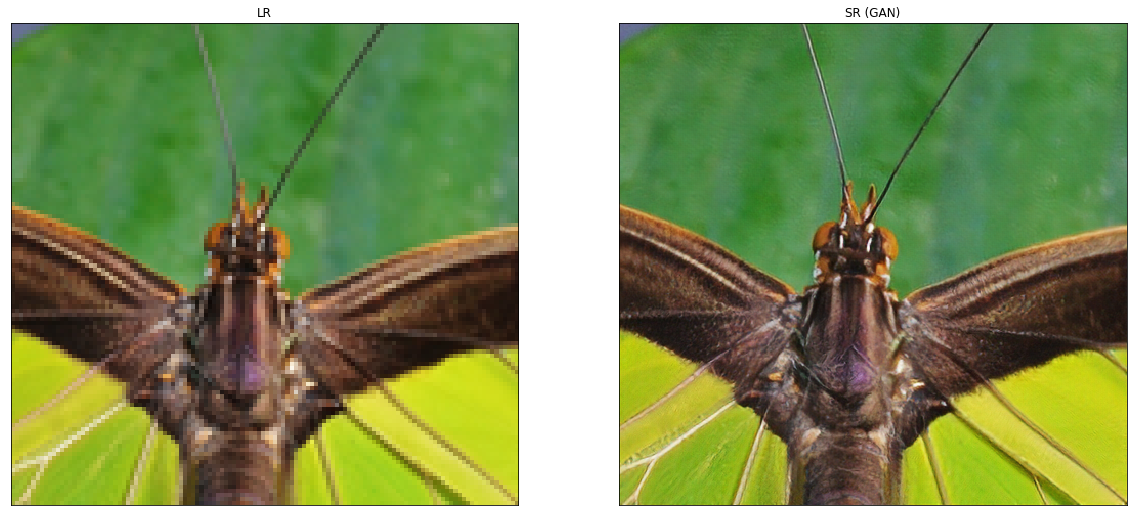

In [33]:
resolve_and_plot_2(os.path.join(example_dir, 'demo/0829x4-crop.png'))

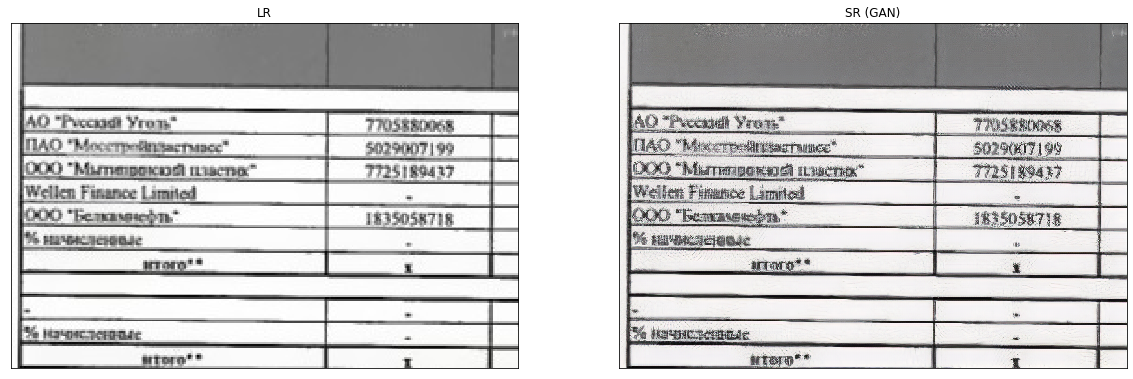

In [34]:
resolve_and_plot_2(os.path.join(example_dir, 'demo/rt.jpg'))

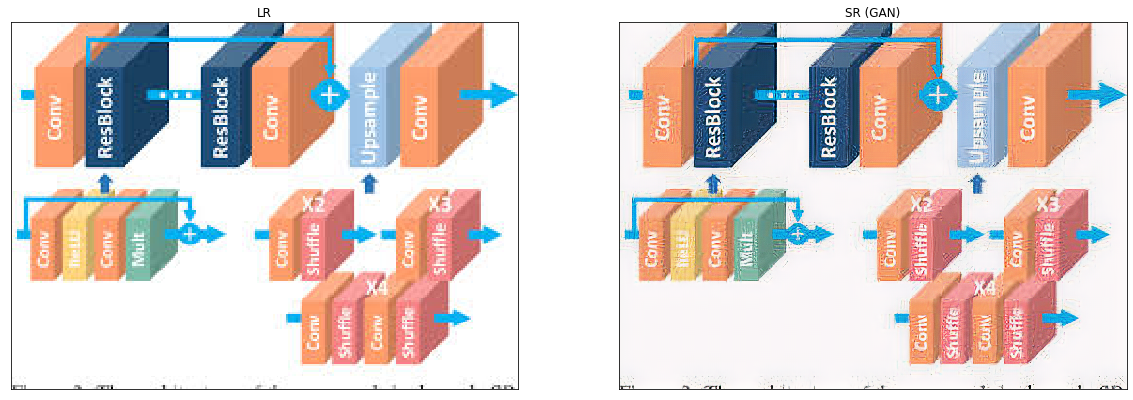

In [17]:
resolve_and_plot_2(os.path.join(example_dir, 'demo/EDSR.jpeg'))

In [0]:
# resolve_and_plot(os.path.join(example_dir, 'demo/0851x4-crop.png'))